# Setting

In [1]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.8 MB/s eta 0:00:00


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=7a6c2ad77d6f0cf7ea003058194a736f27caf6337dcea232e38bab5fea9a178a
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [3]:
!pip install pytorch_msssim torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 7.7 MB/s eta 0:00:00



> Imports



In [4]:
import os
import math
import numpy as np
from numpy import array
from numpy import hstack
import pandas as pd
import netCDF4
import xarray as xr
import pickle
import tensorflow as tf
import seaborn as sns

import keras
from keras import layers, losses, regularizers
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, Cropping2D, RepeatVector, TimeDistributed, LSTM

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve

from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline


In [5]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# print(torch.cuda.get_device_name(0))

Using device: cuda



> Connect to Google drive


In [6]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/')
os.getcwd()


Mounted at /content/drive


'/content/drive/My Drive'

In [7]:
gb_df4 = pd.read_csv('JULES/gb_data4.csv', index_col=0)
gb_data4 = gb_df4.values
print(gb_data4.shape)

scaler4 = preprocessing.MinMaxScaler()
gb_data4 = scaler4.fit_transform(gb_data4)
gb_data4 = np.array(gb_data4, dtype = np.float32)

gb_data4 = np.reshape(gb_data4, (360, 112, 192, 1))

cae_test = gb_data4

print(cae_test.shape)

cae_test = cae_test.astype('float32') # 30 years

(360, 21504)
(360, 112, 192, 1)




## CAE-LSTM Model


In [8]:
def my_encoder_model(input_img):
  act_f = str("relu")# relu

  x = layers.Conv2D(64, (15, 20), activation= act_f, padding='same')(input_img)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(32, (10, 15), activation= act_f, padding='same')(x)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(16, (5, 10), activation= act_f, padding='same')(x)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = Dense(400, activation= act_f)(x)
  x = LeakyReLU(alpha=0.3)(x)
  encoded = Dense(100, activation= act_f)(x)

  return encoded

def my_decoder_model(encoded):
  act_f = str("relu") # relu

  x = Dense(100, activation= act_f)(encoded)
  x = LeakyReLU(alpha=0.3)(x)
  x = Dense(400, activation= act_f)(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = Reshape((16, 25, 1))(x)


  x = layers.Conv2D(16, (5, 10), activation= act_f, padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(32, (10, 15), activation= act_f, padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(64, (15, 20), activation= act_f, padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = Cropping2D(cropping=((16, 0), (8, 0)), data_format=None)(x)
  decoded = layers.Conv2D(1, (15,20), activation='sigmoid', padding='same')(x)
  return decoded


In [9]:
# input shape
input_img = keras.Input(shape=(112, 192, 1))
# for the encoeded data
encoded = my_encoder_model(input_img)
print(encoded.shape)
# for the encoded data
decoded = my_decoder_model(encoded)
print(decoded.shape)

# combine the encode and decode parts as autoencoder
autoencoder = keras.Model(input_img, decoded)

layer_number = 13
# this model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
# this model maps the encoded representation to the original representation
encoded_input = Input(shape=(100,))
decoder = autoencoder.layers[-layer_number](encoded_input)
for i in range(layer_number-1):
  decoder = autoencoder.layers[i-layer_number+1](decoder)
decoder = keras.Model(encoded_input, decoder)

(None, 100)
(None, 112, 192, 1)


In [10]:
from keras.models import load_model
autoencoder = load_model("JULES/para_mod/autoencoder_p_100.h5")
autoencoder_tair = load_model('JULES/para_mod/autoencoder_tair.h5')
autoencoder_rain = load_model('JULES/para_mod/autoencoder_rain.h5')
autoencoder_qair = load_model('JULES/para_mod/autoencoder_qair.h5')
autoencoder_lightning = load_model('JULES/para_mod/autoencoder_lightning.h5')
lstm_model = load_model('JULES/para_mod/lstm_cae_model_100.h5')

In [11]:
input_img = keras.Input(shape=(112, 192, 1))
layer_number = 12


encoder = autoencoder.layers[0](input_img)
for i in range(layer_number):
  encoder = autoencoder.layers[i+1](encoder)
encoder = keras.Model(input_img, encoder)

# this model maps the encoded representation to the original representation
encoded_input = Input(shape=(100,))
decoder = autoencoder.layers[-layer_number](encoded_input)
for i in range(layer_number-1):
  decoder = autoencoder.layers[i-layer_number+1](decoder)
decoder = keras.Model(encoded_input, decoder)

# Data preparation for CAE-LSTM



## Prepare the Climate data



In [12]:
input_img = keras.Input(shape=(144, 192, 1))
layer_number = 14

encoder_tair = autoencoder_tair.layers[0](input_img)
encoder_qair = autoencoder_qair.layers[0](input_img)
encoder_rain = autoencoder_rain.layers[0](input_img)
encoder_lightning = autoencoder_lightning.layers[0](input_img)

for i in range(layer_number):
  encoder_tair = autoencoder_tair.layers[i+1](encoder_tair)
  encoder_rain = autoencoder_rain.layers[i+1](encoder_rain)
  encoder_qair = autoencoder_qair.layers[i+1](encoder_qair)
  encoder_lightning = autoencoder_lightning.layers[i+1](encoder_lightning)
encoder_tair = keras.Model(input_img, encoder_tair)
encoder_rain = keras.Model(input_img, encoder_rain)
encoder_qair = keras.Model(input_img, encoder_qair)
encoder_lightning = keras.Model(input_img, encoder_lightning)

In [13]:
# load the data
tair_df = pd.read_csv('JULES/tair.csv', index_col=0)
tair_data = tair_df.values
tair_data[np.isnan(tair_data)] = 0
# normalization the data
min_max_scaler_tair = preprocessing.MinMaxScaler()
tair_data = min_max_scaler_tair.fit_transform(tair_data)
tair_data = np.array(tair_data, dtype = np.float32)


# encode and re-normalization
tair_data = np.reshape(tair_data, (360, 144, 192, 1))
encoded_tair_data = encoder_tair.predict(tair_data)
test_tair = preprocessing.MinMaxScaler()
encoded_tair_data = test_tair.fit_transform(encoded_tair_data)

print(tair_data.shape)
print(encoded_tair_data.shape)

rain_df = pd.read_csv('JULES/rain.csv', index_col=0)
rain_data = rain_df.values
rain_data[np.isnan(rain_data)] = -0.001
min_max_scaler_rain = preprocessing.MinMaxScaler()
rain_data = min_max_scaler_rain.fit_transform(rain_data)
rain_data = np.array(rain_data, dtype = np.float32)

rain_data = np.reshape(rain_data, (360, 144, 192, 1))
encoded_rain_data = encoder_rain.predict(rain_data)
test_rain = preprocessing.MinMaxScaler()
encoded_rain_data = test_rain.fit_transform(encoded_rain_data)

print(rain_data.shape)
print(encoded_rain_data.shape)

qair_df = pd.read_csv('JULES/qair.csv', index_col=0)
qair_data = qair_df.values
qair_data[np.isnan(qair_data)] = -0.001
min_max_scaler_qair = preprocessing.MinMaxScaler()
qair_data = min_max_scaler_tair.fit_transform(qair_data)
qair_data = np.array(qair_data, dtype = np.float32)

qair_data = np.reshape(qair_data, (360, 144, 192, 1))
encoded_qair_data = encoder_qair.predict(qair_data)
test_qair = preprocessing.MinMaxScaler()
encoded_qair_data = test_qair.fit_transform(encoded_qair_data)

print(qair_data.shape)
print(encoded_qair_data.shape)
# dao zhe le

lightning_df = pd.read_csv('JULES/lightning.csv', index_col=0)
lightning_data = lightning_df.values
min_max_scaler_lightning = preprocessing.MinMaxScaler()
lightning_data = min_max_scaler_tair.fit_transform(lightning_data)
lightning_data = np.array(lightning_data, dtype = np.float32)

lightning_data = np.reshape(lightning_data, (360, 144, 192, 1))
encoded_lightning_data = encoder_lightning.predict(lightning_data)
test_lightning = preprocessing.MinMaxScaler()
encoded_lightning_data = test_lightning.fit_transform(encoded_lightning_data)

print(lightning_data.shape)
print(encoded_lightning_data.shape)

12/12 [==============================] - 9s 34ms/step
(360, 144, 192, 1)
(360, 20)
12/12 [==============================] - 0s 18ms/step
(360, 144, 192, 1)
(360, 20)
12/12 [==============================] - 0s 18ms/step
(360, 144, 192, 1)
(360, 20)
12/12 [==============================] - 0s 17ms/step
(360, 144, 192, 1)
(360, 20)




> Encode and re-normalise the fire data


In [14]:
test_data_gb = encoder.predict(gb_data4)

# re-normalization

test_gb = preprocessing.MinMaxScaler()
test_data_gb = test_gb.fit_transform(test_data_gb)

print(test_data_gb.shape)

12/12 [==============================] - 1s 43ms/step
(360, 100)


# Joint the fire and climate data for CAE-LSTM model

In [15]:
def join_data(gb, tair, rain, qair, lightning):
  join_data = np.zeros((gb.shape[0],100+20*4))
  for i in range(gb.shape[0]):
    coj = []
    coj.extend(gb[i])
    coj.extend(tair[i])
    coj.extend(rain[i])
    coj.extend(qair[i])
    coj.extend(lightning[i])
    coj = np.array(coj)
    coj = np.reshape(coj, (180))
    join_data[i] = coj
  return join_data

cae_encoded_data = join_data(test_data_gb,encoded_tair_data,encoded_rain_data,encoded_qair_data,encoded_lightning_data)
print(cae_encoded_data.shape)

(360, 180)


### Prepare the initial Testing data



> Prepare the testing data




In [16]:
print(cae_encoded_data.shape)

(360, 180)


In [17]:
initial_data = np.expand_dims(cae_encoded_data[:12], axis=0)
rest_true = cae_encoded_data[12:].reshape(29, 12, -1)
print(initial_data.shape)
print(rest_true.shape)

(1, 12, 180)
(29, 12, 180)


### CAE-LSTM



> Iterative prediction



In [18]:
def inner_prediction(input_year):
  this_year = lstm_model.predict(input_year, verbose=0)
  return this_year

def cae_lstm_iterative_prediction(first_year, num_forecast):

  times = num_forecast
  predict_years = np.zeros((times, 12, 180))
  input = first_year
  for i in range(times):
    output = inner_prediction(input)
    predict_years[i] = output[0]
    input_fire = output[:,:,:100]
    this_year_weather = rest_true[i]
    input_weather = np.expand_dims(this_year_weather[:,100:], axis=0)
    input = np.concatenate((input_fire, input_weather), axis=-1)

  y_predict = np.reshape(predict_years, (12*times, 180))
  prediction = y_predict[:,:100]
  prediction = test_gb.inverse_transform(prediction)
  y_decode = decoder.predict(prediction)

  year_mse = []
  pred_year = np.array_split(y_decode, times)

  return np.array(pred_year)

cae_lstm_forecasted_data = cae_lstm_iterative_prediction(initial_data, 29)

11/11 [==============================] - 8s 372ms/step


In [19]:
# '''
# No Real Weather
# Implementaion of the Original paper
# '''

# def inner_prediction(input_year):
#   this_year = lstm_model.predict(input_year, verbose=0)
#   return this_year

# def cae_lstm_iterative_prediction(first_year, num_forecast):

#   times = num_forecast
#   predict_years = np.zeros((times, 12, 180))
#   this_year = first_year
#   for i in range(times):
#     this_year = inner_prediction(this_year)
#     predict_years[i] = this_year[0]
#   y_predict = np.reshape(predict_years, (12*times, 180))
#   prediction = y_predict[:,:100]
#   prediction = test_gb.inverse_transform(prediction)
#   y_decode = decoder.predict(prediction)

#   year_mse = []
#   pred_year = np.array_split(y_decode, times)

#   return np.array(pred_year)

# cae_lstm_forecasted_data = cae_lstm_iterative_prediction(initial_data, 29)

## Original dataset for other models

In [20]:
clip_tair_data = tair_data[:, 27:-5, :, :]

clip_rain_data = rain_data[:, 27:-5, :, :]

clip_qair_data = qair_data[:, 27:-5, :, :]

clip_lightning_data = lightning_data[:, 27:-5, :, :]

gb_joint_data_4 = np.concatenate((gb_data4, clip_tair_data, clip_rain_data, clip_qair_data, clip_lightning_data), axis = 3)

print(gb_joint_data_4.shape)

(360, 112, 192, 5)


## ConvLSTM

In [21]:
convlstm_model = torch.jit.load("JULES/GCN_LSTM_Paper/model_states/convlstm_final_model.pt")



> Prepare inital test data and make rollout prediction



In [22]:
def iterative_forecast(model, initial_data, num_forecasts, device):
    model.eval()

    forecasted_data = []
    input_data = initial_data.to(device)
    # input_data = initial_data

    with torch.no_grad():
        for i in range(num_forecasts):
            # input_data = input_data.squeeze(-1)
            output = model(input_data)

            forecasted_data.append(output.cpu().numpy())

            weather_now = rest_true[i].unsqueeze(0)[:,:,:,:,1:5].to(device)
            # Prepare the input for the next iteration: use the model's output as the new input
            input_data = torch.cat((output, weather_now), dim=4)

    return np.stack(forecasted_data, axis=0)

# Get the initial 12 time steps from the test dataset
initial_test_data = gb_joint_data_4[:12]

initial_test_data = torch.tensor(initial_test_data)

initial_test_data= initial_test_data.unsqueeze(0)

print(initial_test_data.shape)

# Forecast the next 29 years
num_forecasts = 29

rest_true = gb_joint_data_4[12:]

rest_true = torch.tensor(rest_true)
rest_true = rest_true.reshape(num_forecasts, 12, 112, 192, 5)
print(rest_true.shape)

forecasted_data = iterative_forecast(convlstm_model, initial_test_data, num_forecasts, device)
print(forecasted_data.shape)

conv_lstm_forecasted = forecasted_data.reshape(29, 12, 112, 192, 1)

print(conv_lstm_forecasted.shape)

torch.Size([1, 12, 112, 192, 5])
torch.Size([29, 12, 112, 192, 5])
(29, 1, 12, 112, 192, 1)
(29, 12, 112, 192, 1)


# GCN-LSTM model

In [23]:
graph_data = torch.load('JULES/GCN_LSTM_Paper/dataset/ver_sparse_graph_data_v6.pt')
this_edge_index = graph_data['edge_index']
this_edge_weight = graph_data['edge_weight']
print(this_edge_index.shape)
print(this_edge_weight.shape)
print(this_edge_weight)
this_edge_index = this_edge_index.to(device)
this_edge_weight = this_edge_weight.to(device)

torch.Size([2, 2432830])
torch.Size([2432830])
tensor([0.6501, 0.8787, 0.8539,  ..., 0.6040, 0.6359, 0.5310])


In [24]:
gcn_lstm_model = torch.jit.load("JULES/GCN_LSTM_Paper/model_states/gcn_lstm_final_model.pt")

# Conventional LSTM model

In [25]:
conventional_lstm_model = torch.jit.load("JULES/GCN_LSTM_Paper/model_states/conventional_lstm_final_model.pt")

## Data compression preparation for GCN-LSTM

In [26]:
# Load land mask
import netCDF4 as nc
import numpy as np

# Open the netCDF file
nc_file = nc.Dataset('JULES/CRU-NCEPv7.landfrac.nc', mode='r')

# Print the variable names and shapes
print('Variable Names:')
for var_name in nc_file.variables:
    var = nc_file.variables[var_name]
    print(var_name, var.shape)

# Print the dimension names and sizes
print('\nDimension Names and Sizes:')
for dim_name in nc_file.dimensions:
    dim = nc_file.dimensions[dim_name]
    print(dim_name, len(dim))

var = nc_file.variables['field36'][27:-5,:]

# Close the netCDF file
nc_file.close()

# Convert the variable to a NumPy array
land_mask = np.array(var)

# Print the shape of the NumPy array to verify
print(land_mask.shape)

Variable Names:
longitude (192,)
latitude (144,)
field36 (144, 192)

Dimension Names and Sizes:
longitude 192
latitude 144
(112, 192)


In [27]:
def compress_data(data):
    timesteps, height, width, features = data.shape
    compressed_data = data.reshape(timesteps, -1, features)[:, land_mask.flatten() > 0]
    return compressed_data.reshape(timesteps, -1, features)

In [28]:
compressed_test_data = compress_data(gb_joint_data_4)
compressed_test_data = torch.tensor(compressed_test_data, dtype=torch.float32)
print(compressed_test_data.shape)

torch.Size([360, 7771, 5])


## Iterative prediction for GCN-LSTM and LSTM

In [29]:
def iterative_forecast(model, initial_data, num_forecasts, device):
    model.eval()

    forecasted_data = []
    input_data = initial_data.to(device)
    # input_data = initial_data

    with torch.no_grad():
        for i in range(num_forecasts):
            # input_data = input_data.squeeze(-1)
            output = model(input_data)

            forecasted_data.append(output.cpu().numpy())

            weather_now = rest_true[i].unsqueeze(0)[:,:,:,1:5].to(device)
            # Prepare the input for the next iteration: use the model's output as the new input
            input_data = torch.cat((output, weather_now), dim=3)

    return np.stack(forecasted_data, axis=0)

# Get the initial 12 time steps from the test dataset
initial_test_data = compressed_test_data.data[:12]

initial_test_data= initial_test_data.unsqueeze(0)

print(initial_test_data.shape)

# Forecast the next 29 years
num_forecasts = 29

rest_true = compressed_test_data[12:]
rest_true = rest_true.reshape(num_forecasts,12,7771,5)
print(rest_true.shape)

gcn_lstm_forecasted_data = iterative_forecast(gcn_lstm_model, initial_test_data, num_forecasts, device)
print(gcn_lstm_forecasted_data.shape)

conventional_lstm_forecasted_data = iterative_forecast(conventional_lstm_model, initial_test_data, num_forecasts, device)
print(conventional_lstm_forecasted_data.shape)

torch.Size([1, 12, 7771, 5])
torch.Size([29, 12, 7771, 5])
(29, 1, 12, 7771, 1)
(29, 1, 12, 7771, 1)


In [30]:
gcn_lstm_forecasted_data = torch.tensor(gcn_lstm_forecasted_data)
gcn_lstm_forecasted_data = gcn_lstm_forecasted_data.squeeze(1)

pure_lstm_forecasted_data = torch.tensor(conventional_lstm_forecasted_data)
pure_lstm_forecasted_data = pure_lstm_forecasted_data.squeeze(1)

# Mapping back to original shape
def decompress_data(compressed_data, land_mask):
    timesteps, _, num_features = compressed_data.shape
    decompressed_data = np.zeros((timesteps, land_mask.size, num_features))
    decompressed_data[:, land_mask.flatten()> 0, :] = compressed_data
    return decompressed_data.reshape(timesteps, land_mask.shape[0], land_mask.shape[1], num_features)

# GCN LSTM

gcn_lstm_forecasted_data = np.reshape(gcn_lstm_forecasted_data, (-1, 7771, 1))

decompressed_gcn_lstm = decompress_data(gcn_lstm_forecasted_data, land_mask)
gcn_lstm_forecasted = np.squeeze(decompressed_gcn_lstm)
print(gcn_lstm_forecasted.shape)

gcn_lstm_forecasted = gcn_lstm_forecasted.reshape(29, 12, 112, 192, 1)
print(gcn_lstm_forecasted.shape)

# Conventional LSTM

pure_lstm_forecasted_data = np.reshape(pure_lstm_forecasted_data, (-1, 7771, 1))

decompressed_pure_lstm = decompress_data(pure_lstm_forecasted_data, land_mask)
pure_lstm_forecasted = np.squeeze(decompressed_pure_lstm)
print(pure_lstm_forecasted.shape)

pure_lstm_forecasted = pure_lstm_forecasted.reshape(29, 12, 112, 192, 1)
print(pure_lstm_forecasted.shape)

(348, 112, 192)
(29, 12, 112, 192, 1)
(348, 112, 192)
(29, 12, 112, 192, 1)


## Comparision



> The original data for latter comparison



In [31]:
original_test_data = cae_test[12:]
print(original_test_data.shape)

true_data = original_test_data.reshape(29, 12, 112, 192, 1)
print(true_data.shape)

(348, 112, 192, 1)
(29, 12, 112, 192, 1)


# Final result comparison

In [32]:
def mse(true_data, forecasted_data):
    true_data_flatten = true_data.flatten()
    forecasted_data_flatten = forecasted_data.flatten()
    return mean_squared_error(true_data_flatten, forecasted_data_flatten)

def rrmse(true_data, forecasted_data):
    true_data_flatten = true_data.flatten()
    forecasted_data_flatten = forecasted_data.flatten()
    return np.sqrt(mean_squared_error(true_data_flatten, forecasted_data_flatten)) / true_data_flatten.std()

def calc_ssim(true_data, forecasted_data):
    ssim_list = []
    for i in range(true_data.shape[0]): # iterate over big steps
        ssim_val = 0
        for j in range(true_data.shape[1]): # iterate over sub steps
            true_data_2d = true_data[i,j,:,:,0].reshape(true_data.shape[2], true_data.shape[3])
            forecasted_data_2d = forecasted_data[i,j,:,:,0].reshape(forecasted_data.shape[2], forecasted_data.shape[3])
            ssim_val += ssim(true_data_2d, forecasted_data_2d, data_range=forecasted_data_2d.max() - forecasted_data_2d.min())
        ssim_list.append(ssim_val / true_data.shape[1]) # average SSIM over all sub steps
    return ssim_list

def calc_psnr(true_data, forecasted_data):
    psnr_list = []
    for i in range(true_data.shape[0]): # iterate over big steps
        psnr_val = 0
        for j in range(true_data.shape[1]): # iterate over sub steps
            true_data_2d = true_data[i,j,:,:,0].reshape(true_data.shape[2], true_data.shape[3])
            forecasted_data_2d = forecasted_data[i,j,:,:,0].reshape(forecasted_data.shape[2], forecasted_data.shape[3])
            psnr_val += psnr(true_data_2d, forecasted_data_2d, data_range=forecasted_data_2d.max() - forecasted_data_2d.min())
        psnr_list.append(psnr_val / true_data.shape[1]) # average PSNR over all sub steps
    return psnr_list

def calc_loss(true_data, forecasted_data):
    mse_list, rrmse_list = [], []
    for i in range(forecasted_data.shape[0]):
        mse_list.append(mse(true_data[i], forecasted_data[i]))
        rrmse_list.append(rrmse(true_data[i], forecasted_data[i]))
    ssim_list = calc_ssim(true_data, forecasted_data)
    psnr_list = calc_psnr(true_data, forecasted_data)
    return mse_list, rrmse_list, ssim_list, psnr_list

cae_lstm_losses = calc_loss(true_data, cae_lstm_forecasted_data)
gcn_lstm_losees = calc_loss(true_data, gcn_lstm_forecasted)
linear_lstm_losees = calc_loss(true_data, pure_lstm_forecasted)
conv_lstm_losses = calc_loss(true_data, conv_lstm_forecasted)

In [33]:
print(len(cae_lstm_losses))
print(len(cae_lstm_losses[0]))

4
29


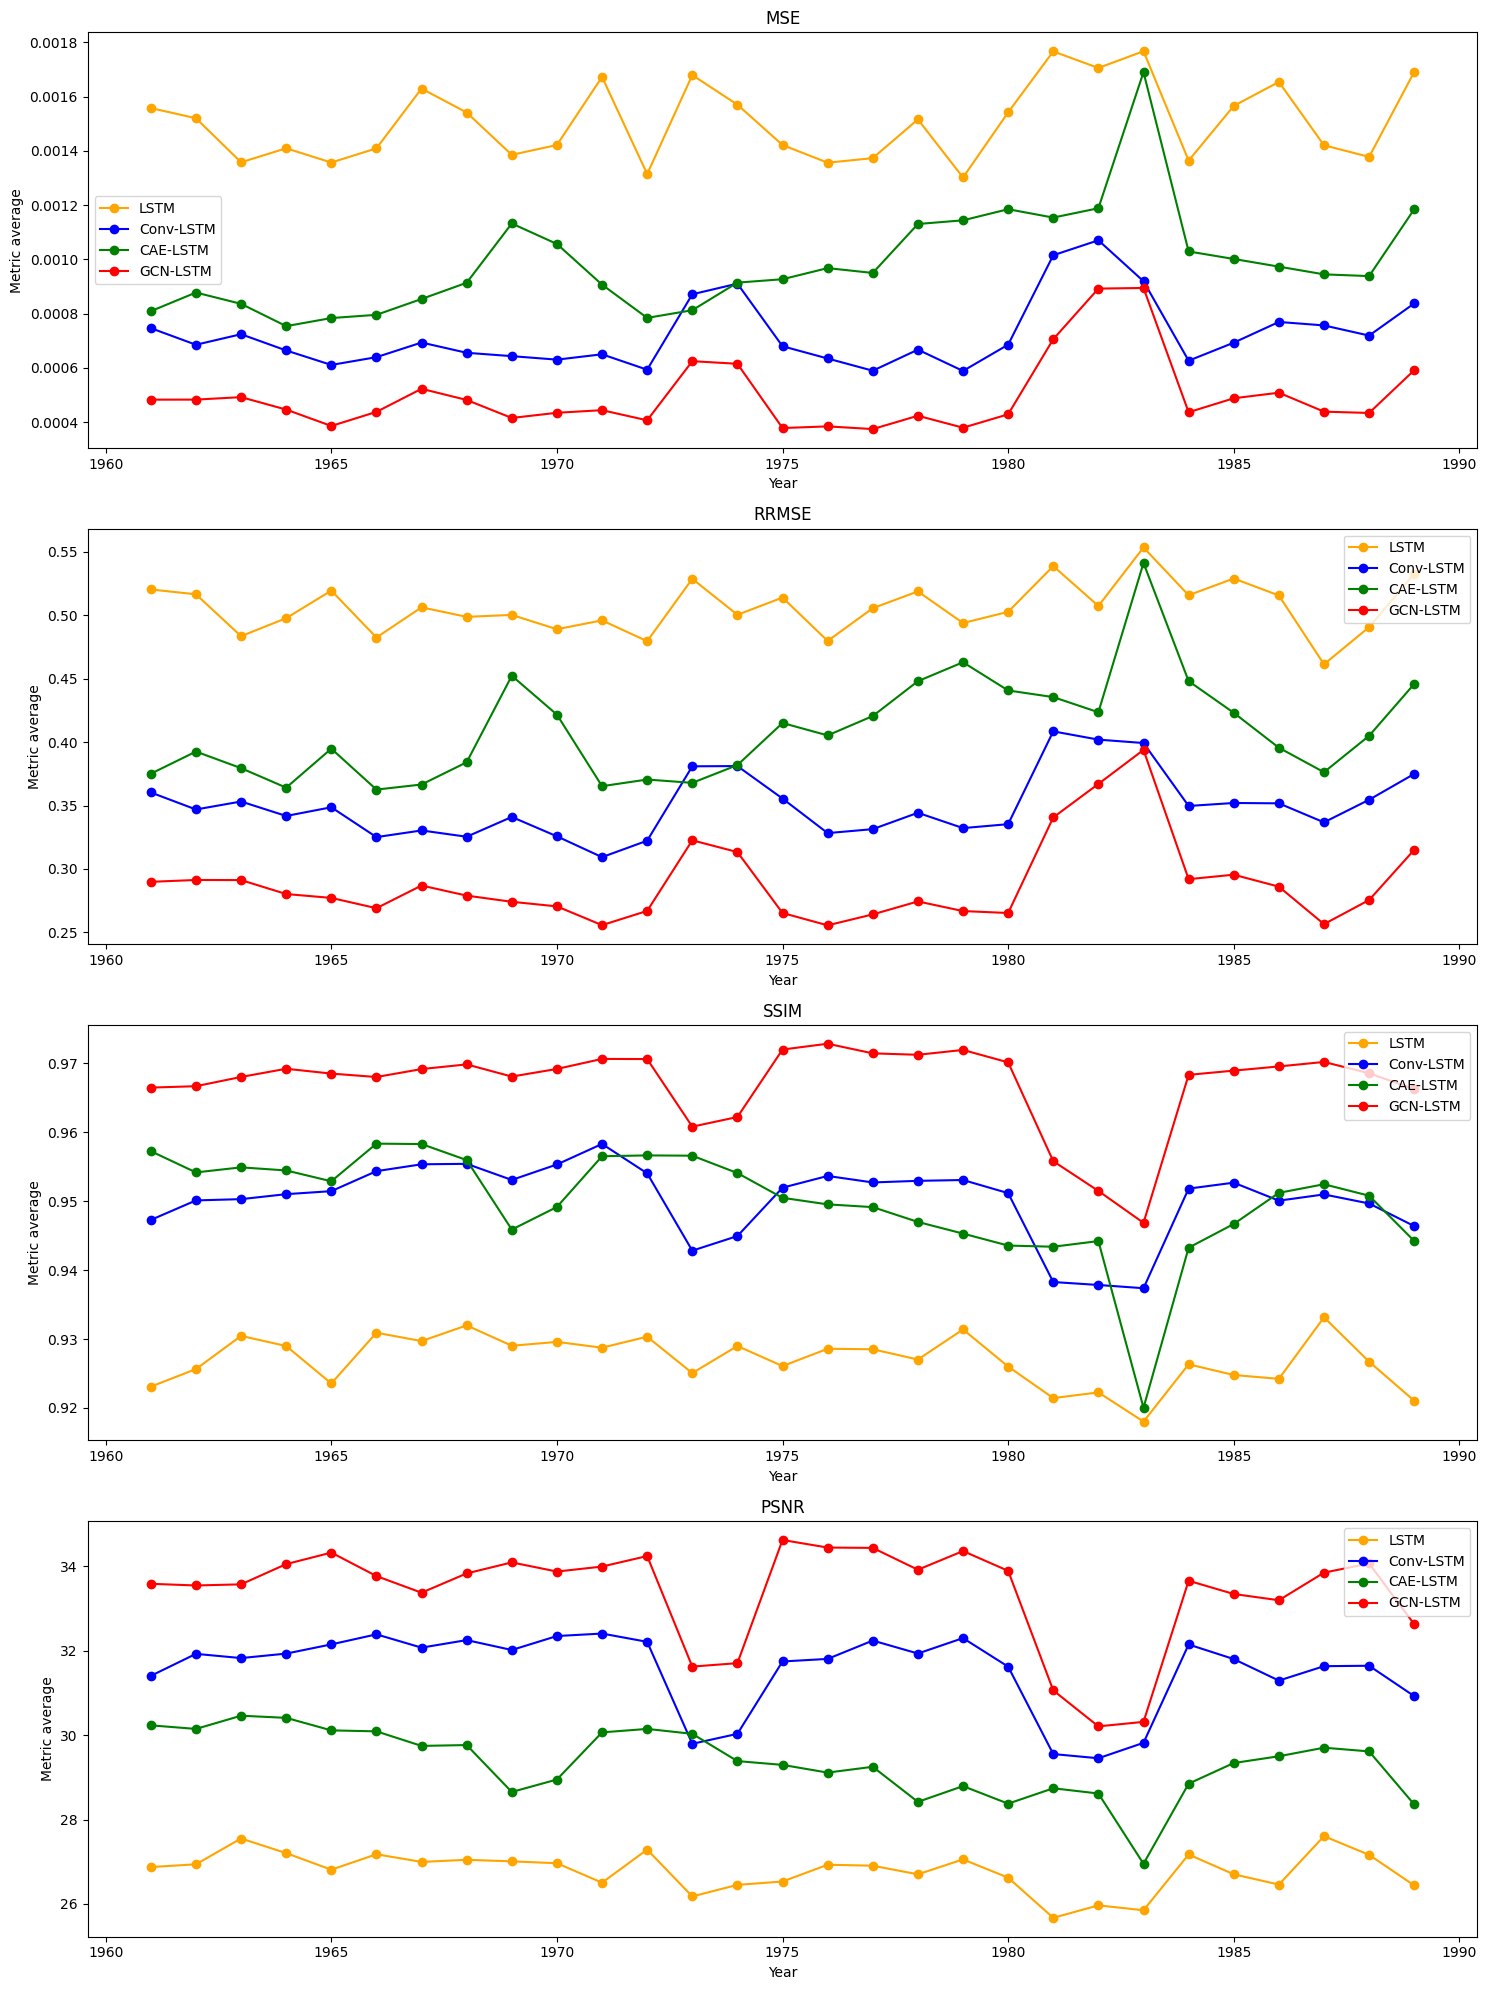

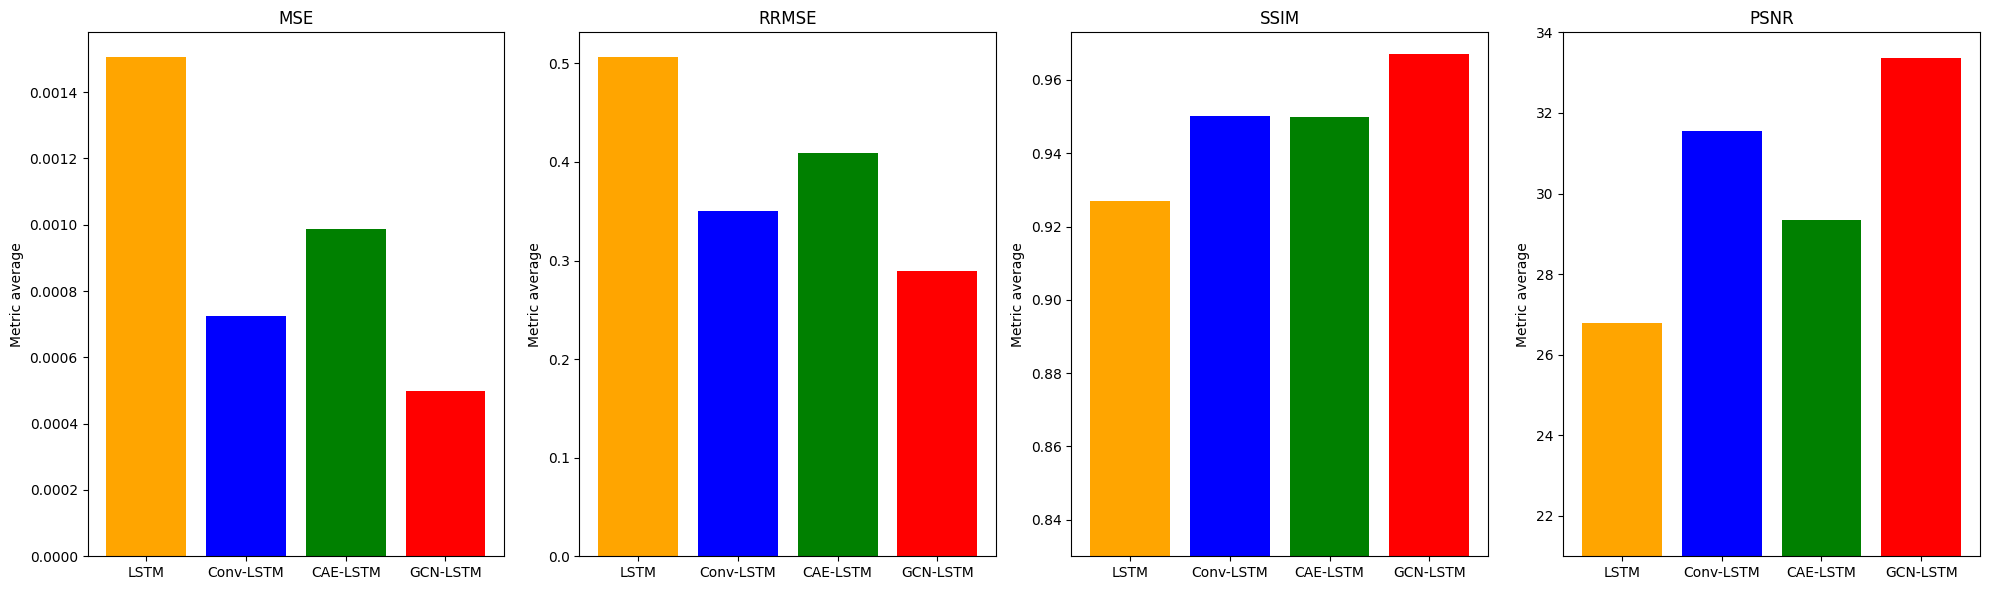

In [34]:
import numpy as np
import matplotlib.pyplot as plt

model1 = np.array(linear_lstm_losees).T
model2 = np.array(conv_lstm_losses).T
model3 = np.array(cae_lstm_losses).T
model4 = np.array(gcn_lstm_losees).T

metrics = ['MSE', 'RRMSE', 'SSIM', 'PSNR']
years = np.arange(1961, 1990)

plt.figure(figsize=(15, 20))
for i, metric in enumerate(metrics):
    plt.subplot(4, 1, i+1)
    plt.plot(years, model1[:, i], 'o-', label='LSTM', color='orange')
    plt.plot(years, model2[:, i], 'o-', label='Conv-LSTM', color='blue')
    plt.plot(years, model3[:, i], 'o-', label='CAE-LSTM', color='green')
    plt.plot(years, model4[:, i], 'o-', label='GCN-LSTM', color='red')
    plt.title(metric)
    plt.xlabel('Year')
    plt.ylabel('Metric average')
    plt.legend()
plt.tight_layout()
plt.show()

avg_losses_model1 = np.mean(model1, axis=0)
avg_losses_model2 = np.mean(model2, axis=0)
avg_losses_model3 = np.mean(model3, axis=0)
avg_losses_model4 = np.mean(model4, axis=0)

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
x = np.arange(4)
for i, metric in enumerate(metrics):
    axs[i].bar(x, [avg_losses_model1[i], avg_losses_model2[i], avg_losses_model3[i], avg_losses_model4[i]], color=['orange', 'blue', 'green', 'red'])
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(['LSTM', 'Conv-LSTM', 'CAE-LSTM', 'GCN-LSTM'])
    axs[i].set_title(metric)
    if metric == 'SSIM':
      axs[i].set_ylim([0.83, 0.973])
    elif metric == 'PSNR':
      axs[i].set_ylim([21, 34])
    axs[i].set_ylabel('Metric average')
plt.tight_layout()
plt.show()



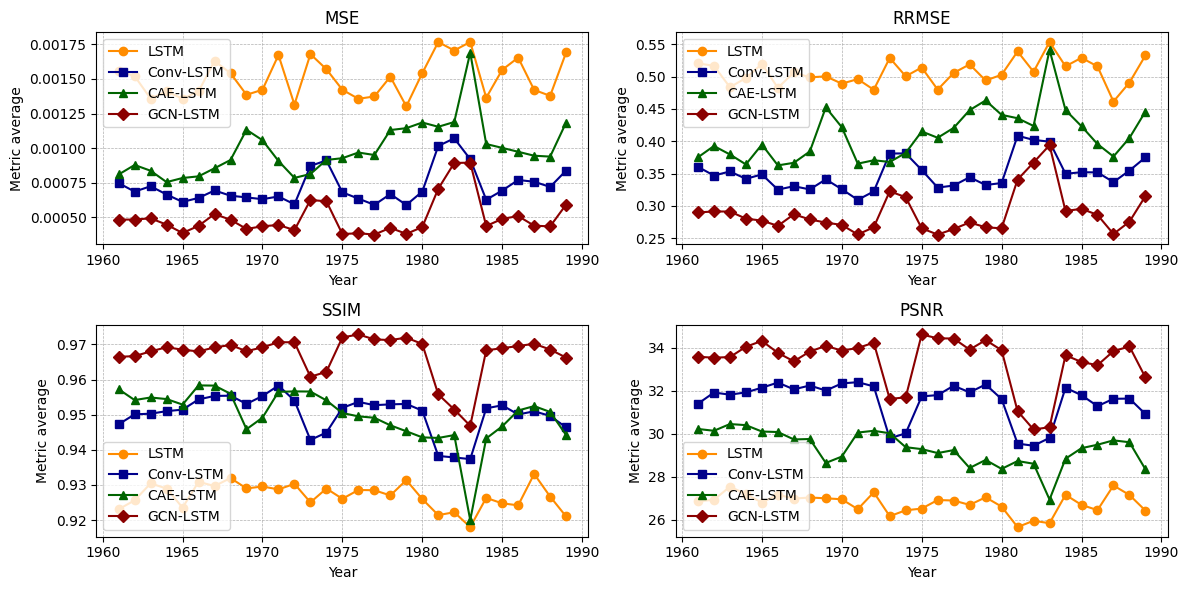

In [35]:
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.plot(years, model1[:, i], '-'+markers[0], label='LSTM', color='darkorange', linewidth=1.5)
    plt.plot(years, model2[:, i], '-'+markers[1], label='Conv-LSTM', color='darkblue', linewidth=1.5)
    plt.plot(years, model3[:, i], '-'+markers[2], label='CAE-LSTM', color='darkgreen', linewidth=1.5)
    plt.plot(years, model4[:, i], '-'+markers[3], label='GCN-LSTM', color='darkred', linewidth=1.5)
    plt.title(metric)
    plt.xlabel('Year')
    plt.ylabel('Metric average')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

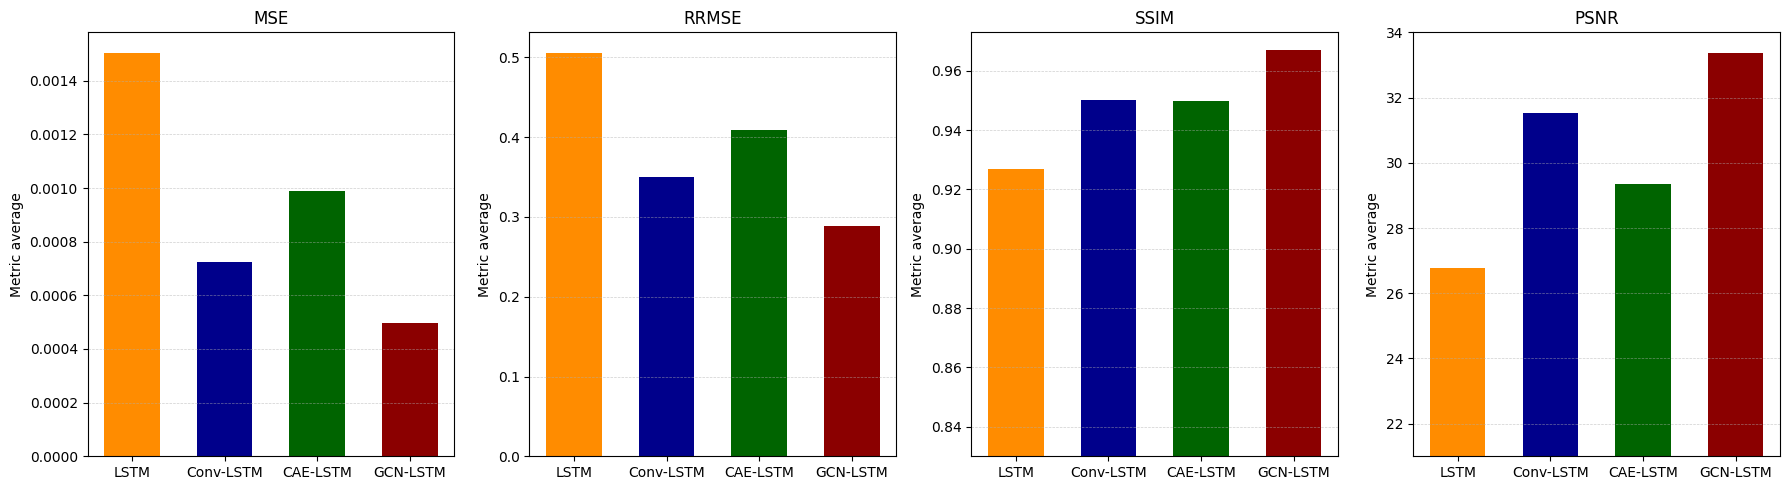

In [36]:
# Define deeper colors for the bars
colors = ['darkorange', 'darkblue', 'darkgreen', 'darkred']

fig, axs = plt.subplots(1, 4, figsize=(18, 5))  # Adjust the figure size
x = np.arange(4)
bar_width = 0.6  # Adjust the bar width for a more academic look

for i, metric in enumerate(metrics):
    axs[i].bar(x, [avg_losses_model1[i], avg_losses_model2[i], avg_losses_model3[i], avg_losses_model4[i]], color=colors, width=bar_width)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(['LSTM', 'Conv-LSTM', 'CAE-LSTM', 'GCN-LSTM'], fontsize=10)
    axs[i].set_title(metric, fontsize=12)
    if metric == 'SSIM':
        axs[i].set_ylim([0.83, 0.973])
    elif metric == 'PSNR':
        axs[i].set_ylim([21, 34])
    axs[i].set_ylabel('Metric average', fontsize=10)
    axs[i].grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)  # Add a light grid for better readability

plt.tight_layout()
plt.show()


In [37]:
avg_losses_model1 = np.mean(model1, axis=0)
avg_losses_model2 = np.mean(model2, axis=0)
avg_losses_model3 = np.mean(model3, axis=0)
avg_losses_model4 = np.mean(model4, axis=0)

df = pd.DataFrame({
    'Metrics': metrics,
    'LSTM': avg_losses_model1,
    'Conv-LSTM': avg_losses_model2,
    'CAE-LSTM': avg_losses_model3,
    'GCN-LSTM': avg_losses_model4,
})

print(df)


  Metrics       LSTM  Conv-LSTM   CAE-LSTM   GCN-LSTM
0     MSE   0.001505   0.000723   0.000988   0.000498
1   RRMSE   0.506152   0.349927   0.409151   0.288990
2    SSIM   0.926949   0.950138   0.949862   0.966979
3    PSNR  26.784032  31.541234  29.348344  33.366938


In [38]:
num_timesteps = 12
flat_true_data = true_data.reshape(348, 112, 192)
flat_pure_lstm_forecasted = pure_lstm_forecasted.reshape(348, 112, 192)
flat_conv_lstm_forecasted = conv_lstm_forecasted.reshape(348, 112, 192)
flat_cae_lstm_forecasted_data = cae_lstm_forecasted_data.reshape(348, 112, 192)
flat_gcn_lstm_forecasted = gcn_lstm_forecasted.reshape(348, 112, 192)

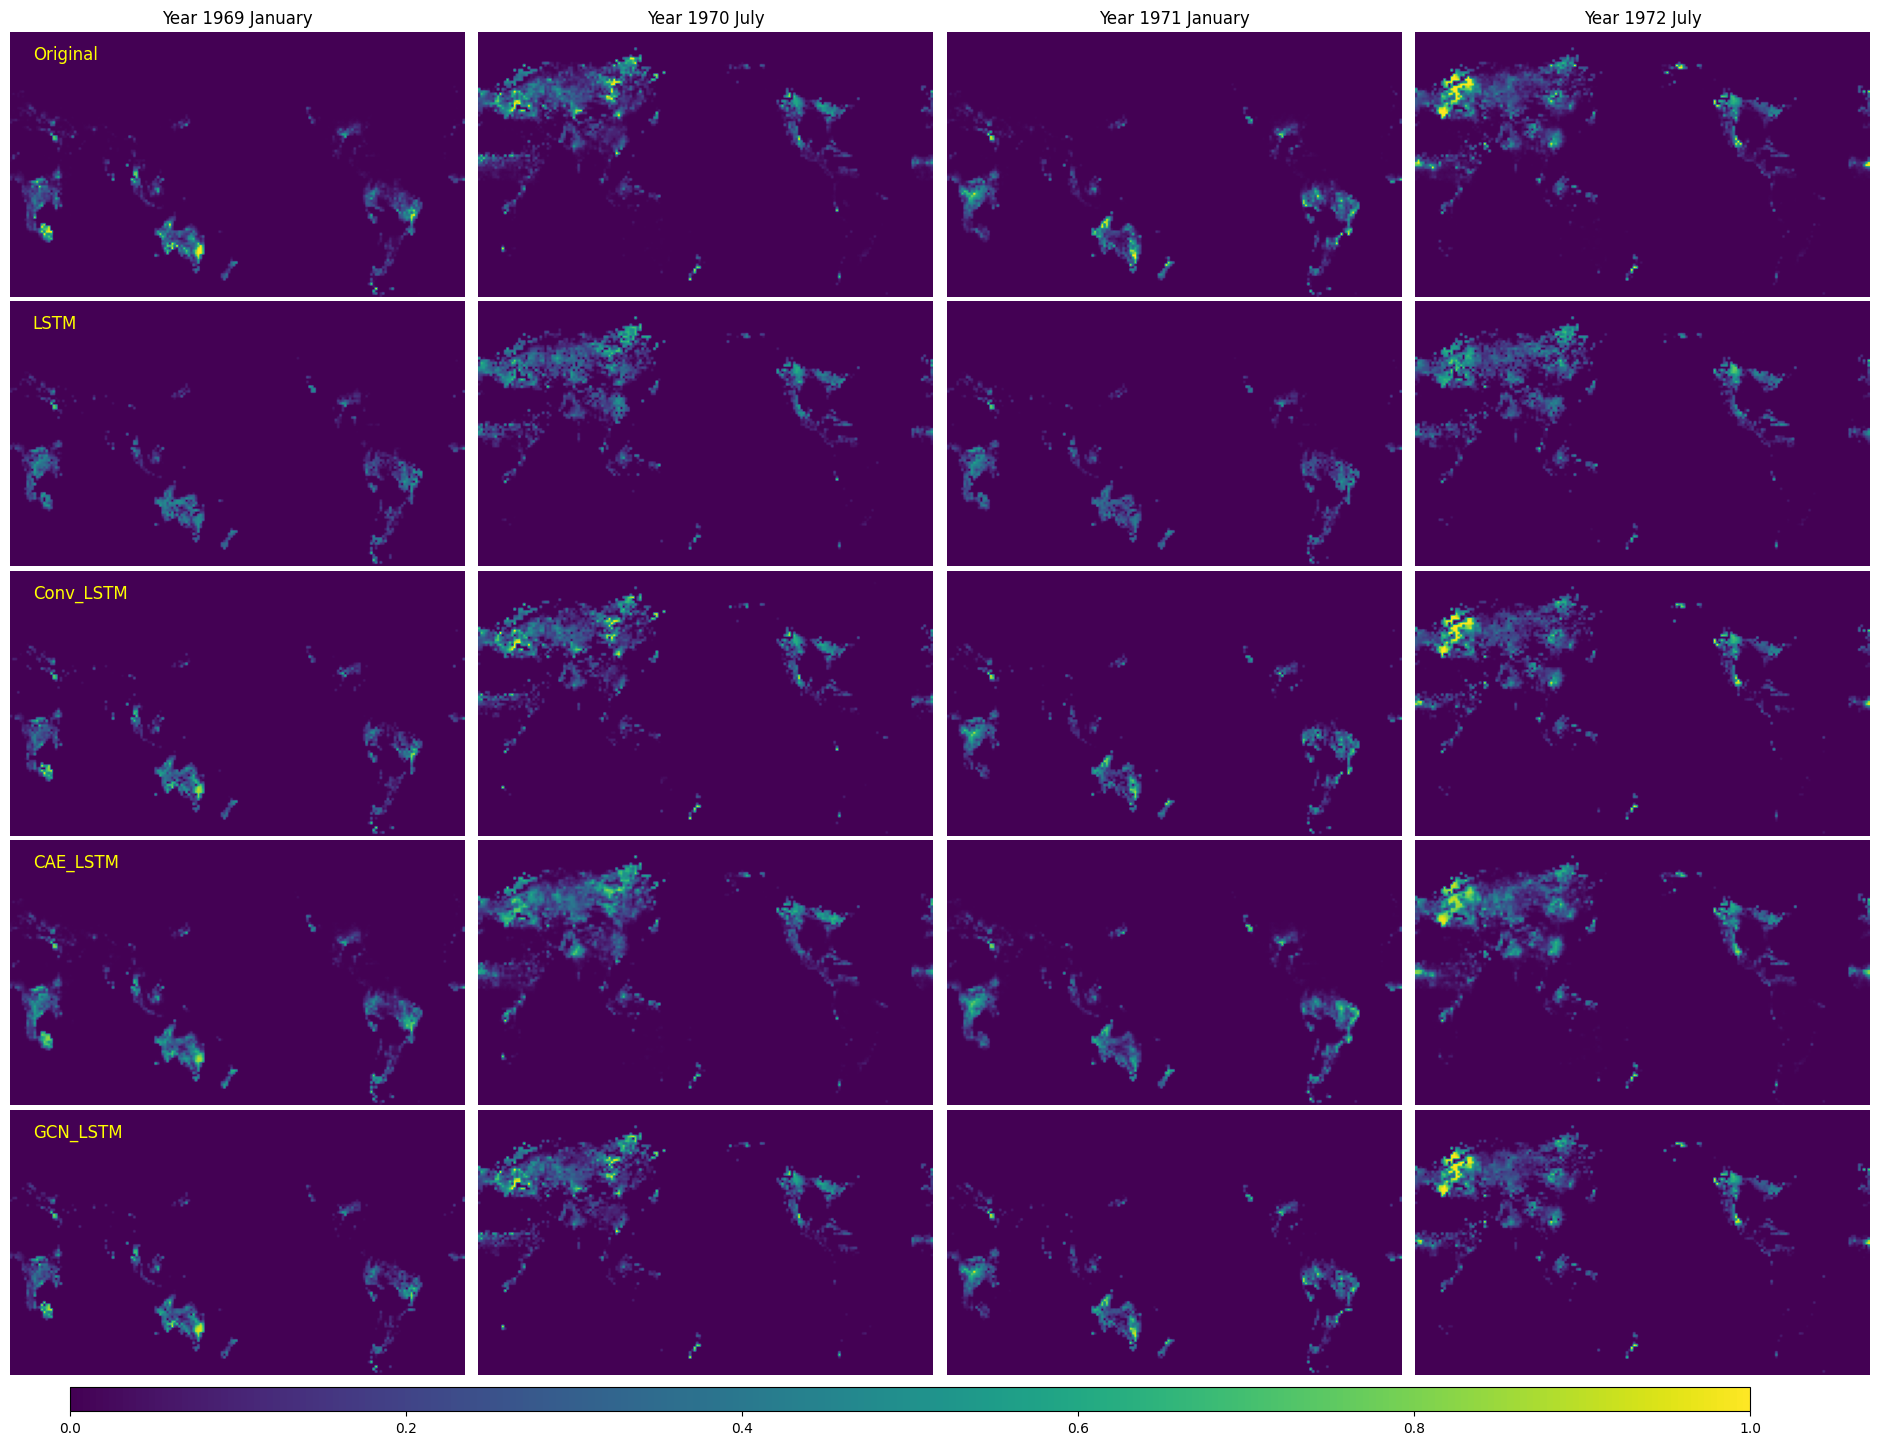

In [39]:
num_timesteps = 12
def show_comp_methods(original_test_data, pure, conv, cae, gcn, begin_year, interval_year=1):
    fig, axes = plt.subplots(5, 4, figsize=(24, 24), facecolor='w')
    models = [original_test_data, pure, conv, cae, gcn]  # Add original_test_data to models for simplicity
    model_names = ["Original", "LSTM", "Conv_LSTM", "CAE_LSTM", "GCN_LSTM"]

    monthly_field = np.zeros((112, 192))
    norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

    for m, model in enumerate(models):
        for j in range(4):
          ax = axes[m, j]
          for i in range(112):
              for k in range(192):
                if j % 2 == 0:
                  monthly_field[i,k] = np.array(model[(begin_year-1)*num_timesteps+interval_year*j*num_timesteps][~i][k])
                else:
                  monthly_field[i,k] = np.array(model[(begin_year-1)*num_timesteps+interval_year*j*num_timesteps + 6][~i][k])

          # Set title only for the top row
          if m == 0:
            if j % 2 == 0:
              ax.set_title(f'Year {int(j*interval_year) + 1961 + begin_year} January')
            else:
              ax.set_title(f'Year {int(j*interval_year) + 1961 + begin_year} July')

          ax.imshow(monthly_field, norm=norm)
          ax.axis('off')  # Turn off axis

          # Add model names to the left of the first column
          if j == 0:
            # ax.text(0.05, 0.95, model_names[m], color='white', transform=ax.transAxes, verticalalignment='top', fontsize=12, ha='left', bbox=dict(facecolor='black', alpha=0.5, boxstyle="round,pad=0.3"))
            ax.text(0.05, 0.95, model_names[m], color='yellow', transform=ax.transAxes, verticalalignment='top', fontsize=12, ha='left')

    # Add a single colorbar at the bottom
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.15, 0.2, 0.7, 0.01])  # Position of the colorbar
    plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')

    plt.subplots_adjust(hspace=-0.65, wspace=0.03)
    plt.show()

show_comp_methods(flat_true_data, flat_pure_lstm_forecasted, flat_conv_lstm_forecasted, flat_cae_lstm_forecasted_data, flat_gcn_lstm_forecasted, 8, 1)


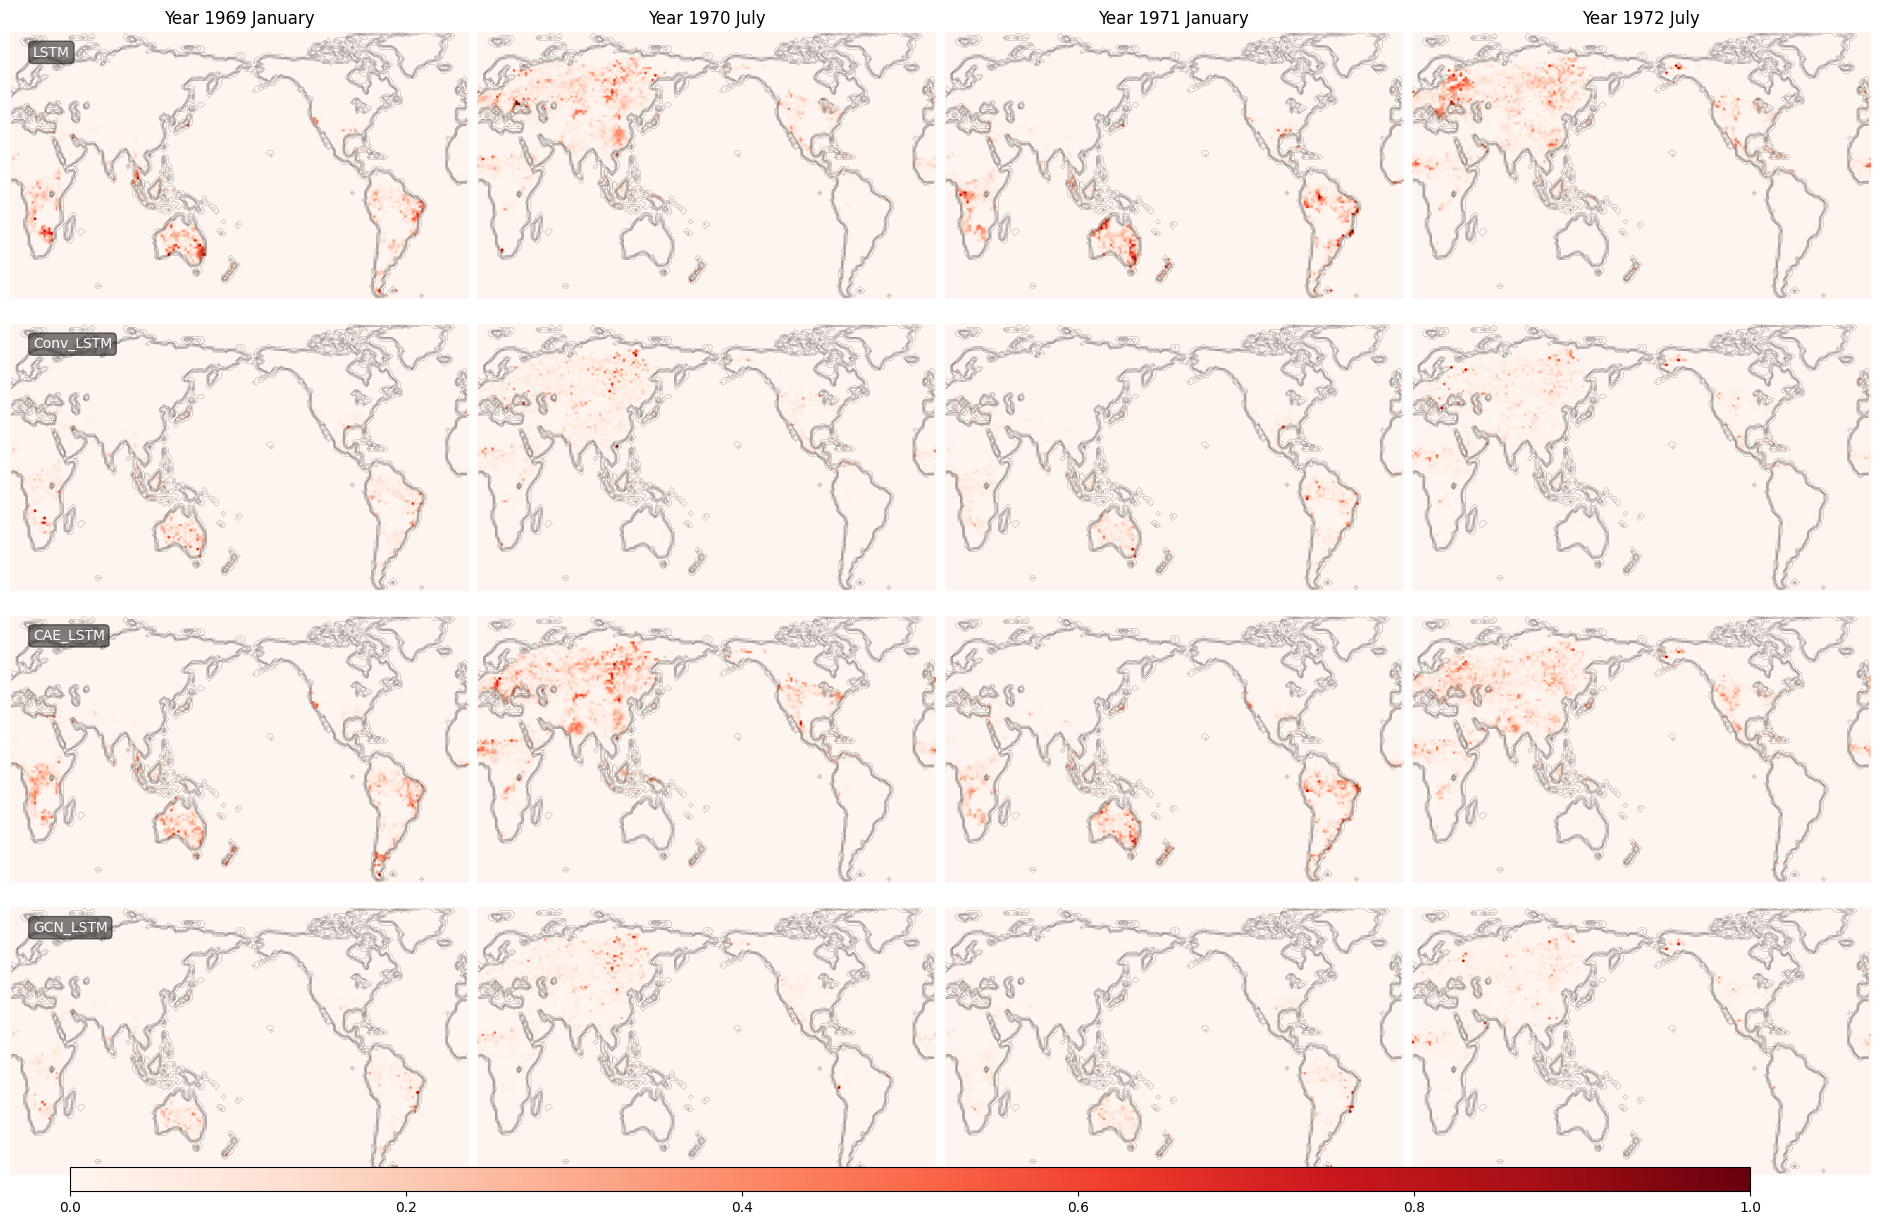

In [40]:
def show_diff_methods(original_test_data, pure, conv, cae, gcn, begin_year, interval_year):
    fig, axes = plt.subplots(4, 4, figsize=(24, 24), facecolor='w')
    models = [pure, conv, cae, gcn]
    model_names = ["LSTM", "Conv_LSTM", "CAE_LSTM", "GCN_LSTM"]

    monthly_field = np.zeros((112, 192))
    norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

    for m, model in enumerate(models):
        for j in range(4):
            ax = axes[m, j]
            for i in range(112):
                for k in range(192):
                  if j % 2 == 0:
                    original_val = original_test_data[(begin_year-1)*num_timesteps+interval_year*j*num_timesteps][~i][k]
                    model_val = model[(begin_year-1)*num_timesteps+interval_year*j*num_timesteps][~i][k]
                  else:
                    original_val = original_test_data[(begin_year-1)*num_timesteps+interval_year*j*num_timesteps + 6][~i][k]
                    model_val = model[(begin_year-1)*num_timesteps+interval_year*j*num_timesteps + 6][~i][k]

                  monthly_field[i,k] = abs(original_val - model_val)

            # Set title only for the top row
            if m == 0:
              if j % 2 == 0:
                ax.set_title(f'Year {int(j*interval_year) + 1961 + begin_year} January')
              else:
                ax.set_title(f'Year {int(j*interval_year) + 1961 + begin_year} July')

            ax.imshow(monthly_field, cmap=plt.cm.Reds)  # use Reds colormap
            ax.axis('off')  # Turn off axis
            ax.contour(land_mask[::-1], colors='k', linewidths = 0.1)  # add land mask with black color

            # Add model names to the left of the first column
            if j == 0:
              ax.text(0.05, 0.95, model_names[m], color='white', transform=ax.transAxes, verticalalignment='top', fontsize=10, ha='left', bbox=dict(facecolor='black', alpha=0.5, boxstyle="round,pad=0.3"))
            # ax.text(-0.1, 0.5, model_names[m], rotation=0, transform=ax.transAxes, verticalalignment='center', fontsize=14, ha='right')

    # Add a single colorbar at the bottom
    sm = plt.cm.ScalarMappable(norm=norm)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Reds)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.15, 0.25, 0.7, 0.01])  # Position of the colorbar
    plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')

    plt.subplots_adjust(hspace=-0.7, wspace=0.02)
    plt.show()

show_diff_methods(flat_true_data, flat_pure_lstm_forecasted, flat_conv_lstm_forecasted, flat_cae_lstm_forecasted_data, flat_gcn_lstm_forecasted, 8, 1)


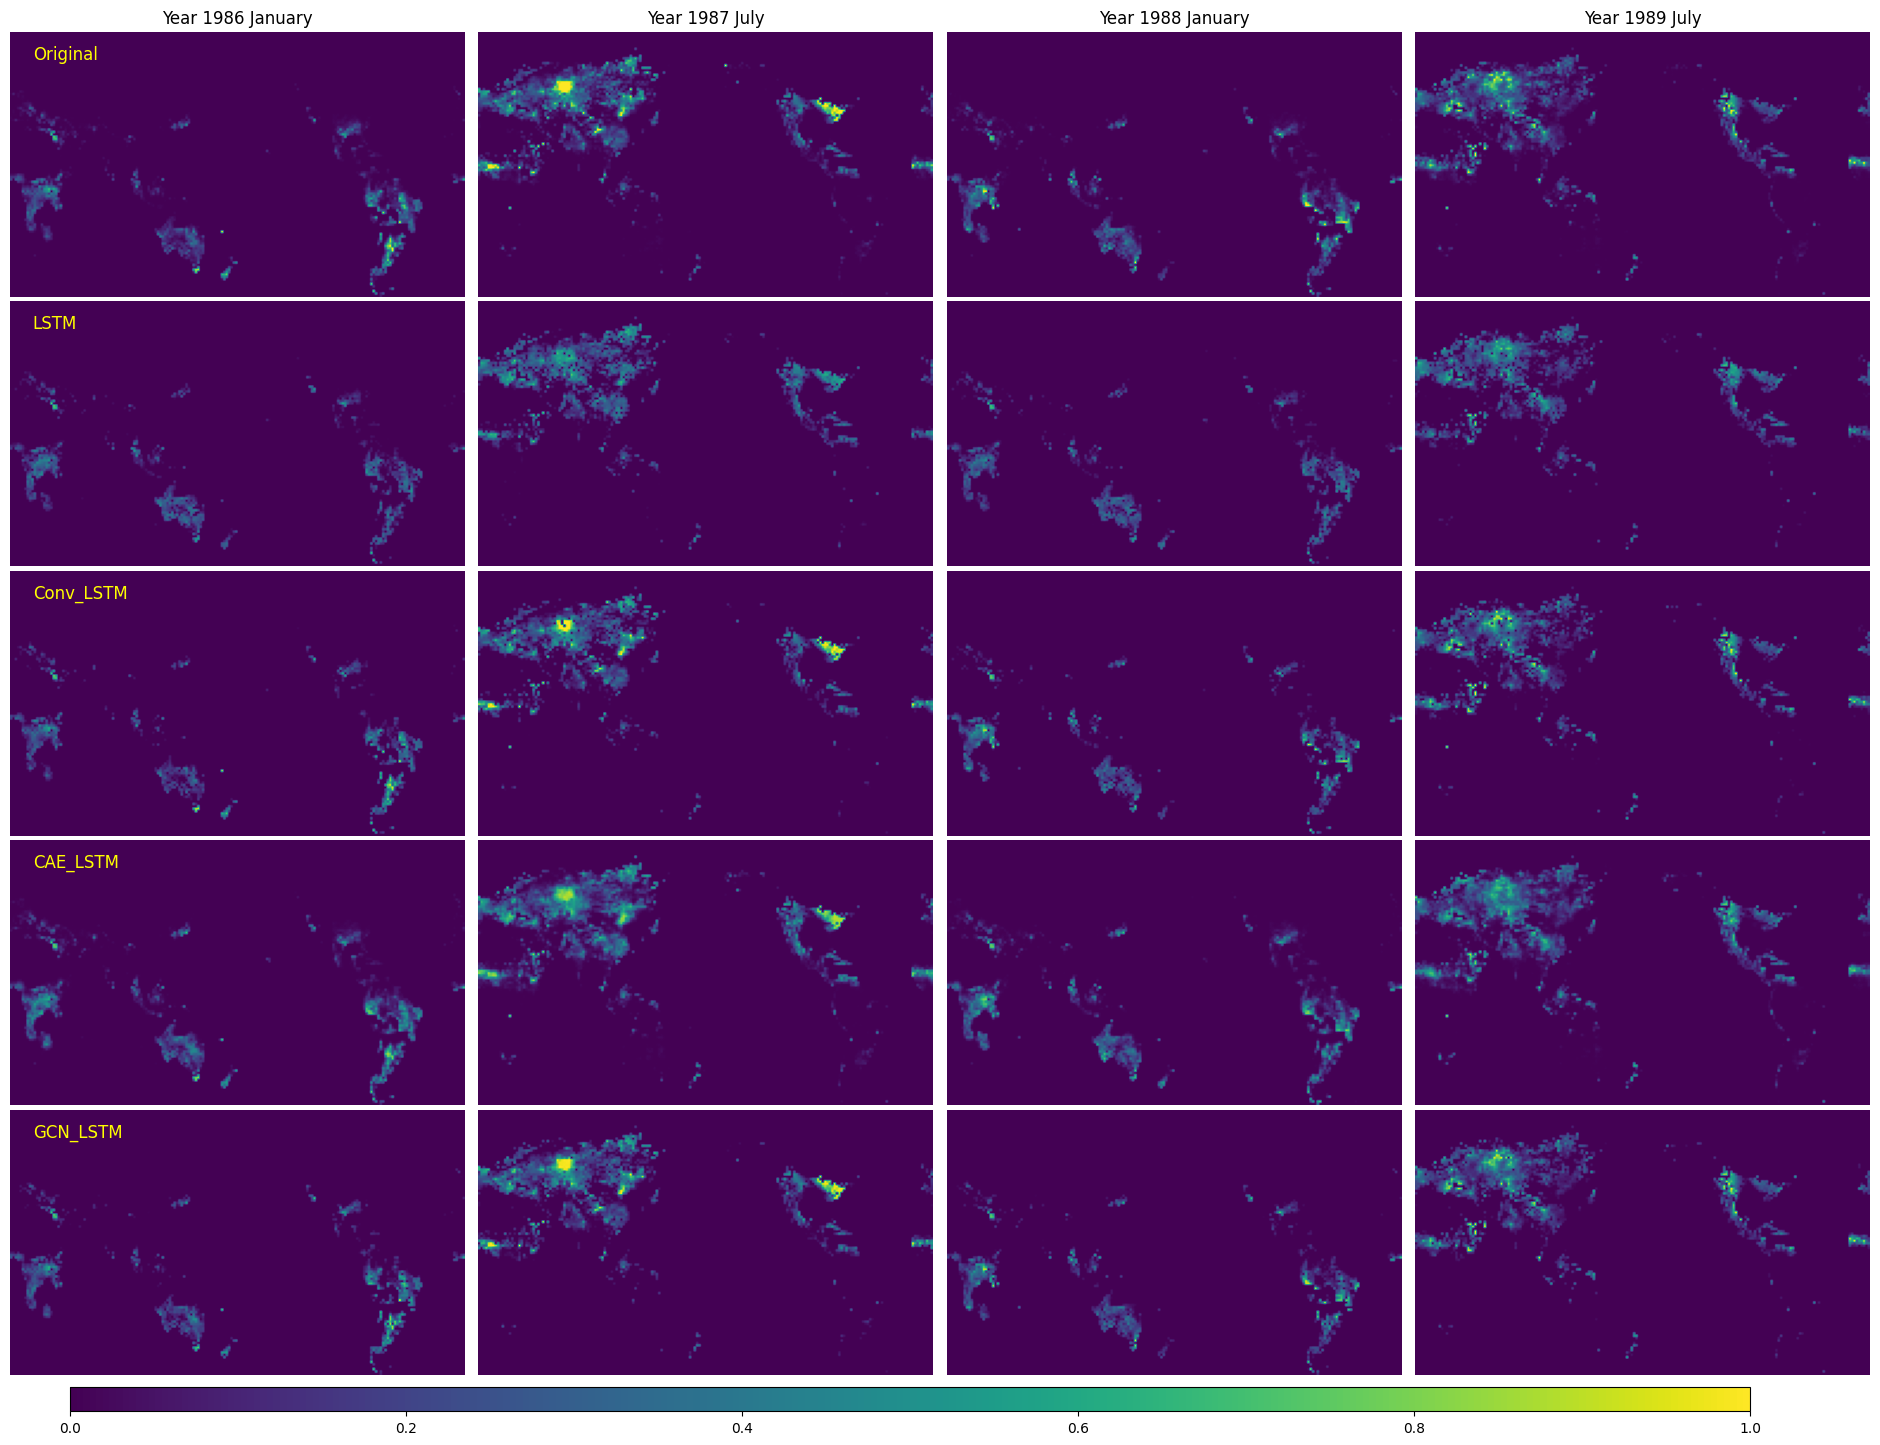

In [47]:
show_comp_methods(flat_true_data, flat_pure_lstm_forecasted, flat_conv_lstm_forecasted, flat_cae_lstm_forecasted_data, flat_gcn_lstm_forecasted, 25, 1)

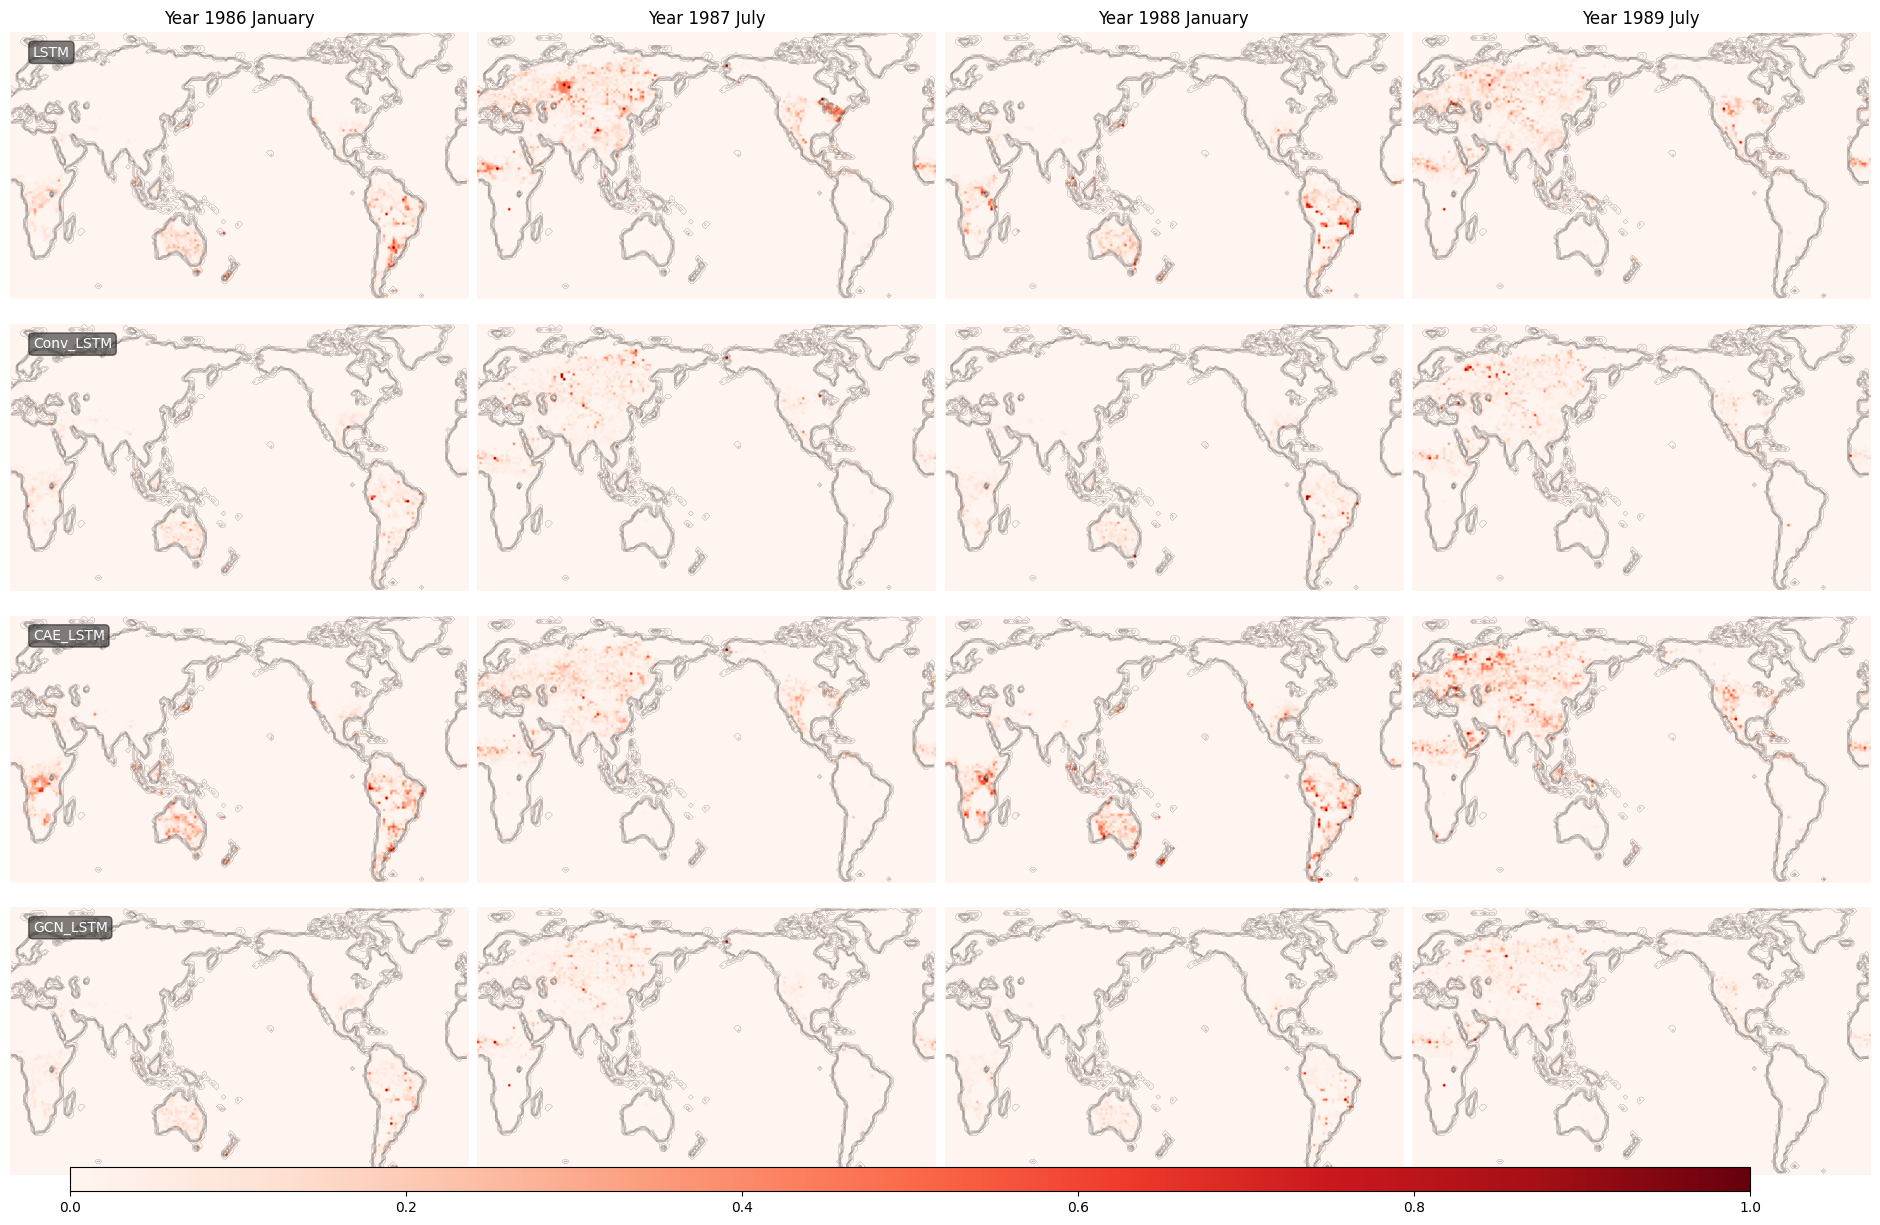

In [48]:
show_diff_methods(flat_true_data, flat_pure_lstm_forecasted, flat_conv_lstm_forecasted, flat_cae_lstm_forecasted_data, flat_gcn_lstm_forecasted, 25, 1)